# Supplementary Figure 3

**Summary:**

- **Panel a:** Quantification of sequencing adapters in soft-clips regions

- **Panel b:** Origin of supplementary alignments

- **Panel c:** Size distribution of supplementary alignments


---
<br>



## Import libraries

In [1]:
import re
import pandas as pd
import numpy as np
import pysam
import parasail
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import ticker
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from upsetplot import plot
from scipy.stats import gaussian_kde

## Settings for saving figures as pdf

In [2]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Set environmental constants

In [3]:
# Set path where files are stored
path = '/Volumes/elegans/rna_sequencing'

## Opening Dataset file

In [4]:
# Open dataset generated as part of the pre-processing step
dataset = pd.read_csv(f'{path}/dataset_+SSP+SL+HAIRPIN.tsv', sep='\t')

In [5]:
genes_start = pd.read_csv(f'{path}/start_positions_stats.tsv', sep='\t')

---

<br>

# Panel a: Quantification of sequencing adapters

## 1. Search for poly(A) adapters in SSP datasets

In [6]:
DEFAULT_ALIGN_PARAMS = {'match': 1,
                        'mismatch': 0,
                        'gap_open': 2,    # penalty to create a gap
                        'gap_extend': 1}  # penalty to extend a gap (must have created before)


def semi_global_alignment(reference, query, params=DEFAULT_ALIGN_PARAMS):

    subs_mat = parasail.matrix_create("ACGT", params['match'], params['mismatch'])
    alignment = parasail.sg_trace_striped_32(reference, query, params['gap_open'], params['gap_extend'], subs_mat)

    return alignment

In [7]:
def evaluate_alignment(sequence, motif, seqtype, sensitivity=0.7):
    
    ref = len(motif)
    
    # initialize
    aln_score = None
    aln_size = None
    
    # initial alignment (full seq)
    aln = semi_global_alignment(sequence, motif)
    score = aln.score
    
    # shorter alignments
    if score < len(motif) * sensitivity:
        
        for pos in reversed(range(15, len(motif), 1)):
            
            if seqtype == "5SC":
                aln = semi_global_alignment(sequence, motif[-pos:])
            elif seqtype == "3SC":
                aln = semi_global_alignment(sequence, motif[:pos])
            else:
                break
                
            score = aln.score

            if score < sensitivity * pos:
                continue
            else:
                aln_score = score
                aln_size = pos
                break
    else:
        aln_score = score
        aln_size = len(motif)
        
    return aln_score, aln_size

In [8]:
def search_polyA_sequence(read):
    
    aln_end = read.query_alignment_end

    if len(read.seq)-aln_end >= 20:
        SC3_sequence = str(read.seq[aln_end:])
        POLYA_score, POLYA_size = evaluate_alignment(SC3_sequence, 'AAAAAAAAAAGAAGATAGAGCGACAGGC', '3SC')
    else:
        POLYA_score = None 
        POLYA_size = None 

    return POLYA_score, POLYA_size

In [9]:
def measure_sequence_found(dataframe):
    
    df_list = []
    
    for i in ['SSP', 'SL', 'Poly(A)']:
        df = pd.DataFrame(dataframe[i].value_counts())
        df_list.append(df)

    return pd.concat(df_list, axis=1)

In [10]:
runs = ['SSP_1', 'SSP_2', 'SSP_3', 'SSP_4', 'SSP_5', 'SSP_6']
rows = []

for ID in runs:

    input_file = f'{path}/{ID}/{ID}-transcriptome_sorted.bam'

    with pysam.AlignmentFile(input_file,'rb') as alignments:

        for read in alignments:

            if not read.is_unmapped and not read.is_supplementary and read.seq is not None:
                
                name = read.query_name
                score, size = search_polyA_sequence(read)

                rows.append({'read': name, 'PolyA_score': score, 'PolyA_size': size})
                        
polyA_search = pd.DataFrame(rows)
polyA_search = polyA_search.fillna(False)

In [11]:
# gets reads from SSP runs
d = dataset[dataset['run'].isin(['SSP_1', 'SSP_2', 'SSP_3', 'SSP_4', 'SSP_5', 'SSP_6'])]
# select columns of interest
d = d[['read', 'read_orientation', 'softclip', 'run', 'SSP_score', 'SSP_size', 'SSP_dist', 'SSP_FOUND', 'SL', 'SL_score', 'SL_distance', 'ROBUST_SL_FOUND' ]]
# merge with poly(A) search
data = polyA_search.merge(d, on='read', how='right')

In [12]:
# determine if poly(A) was found or not
data['PolyA_FOUND'] = data['PolyA_score'].apply(lambda x: True if x > 15 else False)
data['SSP_FOUND'] = data['SSP_FOUND'].apply(lambda x: 'FOUND' if x == 'FOUND' else 'NOT FOUND')
data['ROBUST_SL_FOUND'] = data['ROBUST_SL_FOUND'].apply(lambda x: 'FOUND' if x == 'FOUND' else 'NOT FOUND')

In [13]:
# Split reads in 3 categories based on orientation and length of 5' soft-clip 
sense = data[data['read_orientation'] == 'sense']
long_antisense = data[(data['read_orientation'] == 'antisense') & (data['softclip'] == 1)]
short_antisense = data[(data['read_orientation'] == 'antisense') & (data['softclip'] == 0)]

<br>

## 2. Sense reads

Per ONT documentation, the SSP region enter the nanopore first (5' end of the cDNA sense strand) and the poly(A)+VNP adapters exits last (3' end)

In [14]:
# add together
sense_summary = sense[['ROBUST_SL_FOUND','SSP_FOUND','PolyA_FOUND']].copy()
sense_summary.columns = ['SL', 'SSP', 'Poly(A)']
sense_summary['SL'] = sense_summary['SL'].map({'NOT FOUND':False, 'FOUND':True})
sense_summary['SSP'] = sense_summary['SSP'].map({'NOT FOUND':False, 'FOUND':True})

In [15]:
measure_sequence_found(sense_summary)

,SSP,SL,Poly(A)
True,56876,15849,52895
False,42985,84012,46966


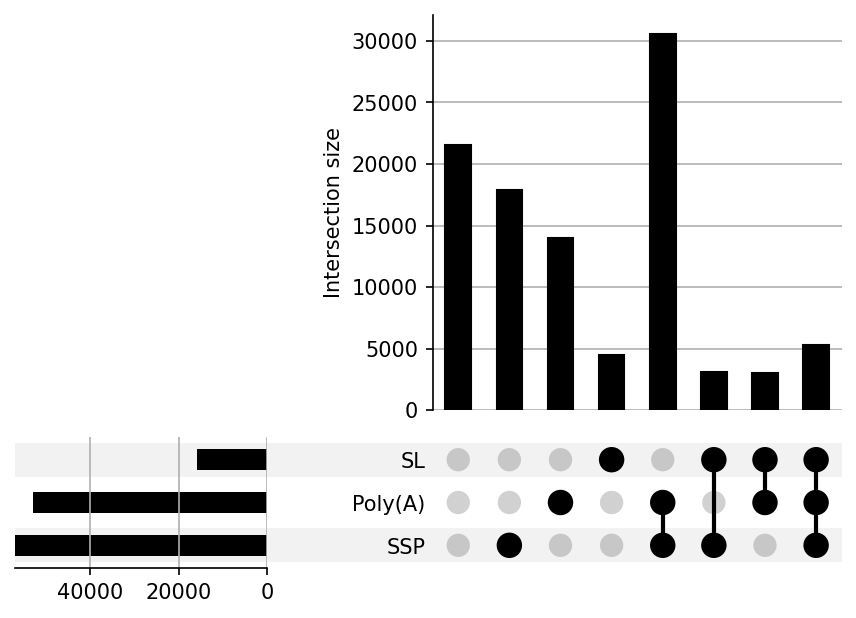

In [16]:
%matplotlib inline

# Count genes per set
sense_cat = sense_summary.groupby(['SSP', 'Poly(A)', 'SL']).size()

# Show upset plot
upset_plot = plot(sense_cat, fig=plt.figure(figsize=(8,4),dpi=150), sort_categories_by=None, facecolor='k', sort_by='degree', totals_plot_elements=5, intersection_plot_elements=8)

# Save plot
plt.savefig('SupFig3.a-upset_adapter_search_(sense).pdf', dpi=800, bbox_inches='tight')

<font size="4">**Sup. Fig 3.a:**<br></font>
For each read evaluated, we performed a sequence search for the SSP and SL motifs on the 5’ soft-clip region, and for the poly(A) motif on the 3’ soft-clip region.
**Sense reads :** (n = 99,861 reads)

<br>

## 3. Antisense reads with short 5' soft-clips

In [17]:
short_antisense_summary = short_antisense[['ROBUST_SL_FOUND','SSP_FOUND','PolyA_FOUND']].copy()
short_antisense_summary.columns = ['SL', 'SSP', 'Poly(A)']
short_antisense_summary['SL'] = short_antisense_summary['SL'].map({'NOT FOUND':False, 'FOUND':True})
short_antisense_summary['SSP'] = short_antisense_summary['SSP'].map({'NOT FOUND':False, 'FOUND':True})

In [18]:
measure_sequence_found(short_antisense_summary)

,SSP,SL,Poly(A)
False,109855,138592,46142
True,63766,35029,127479


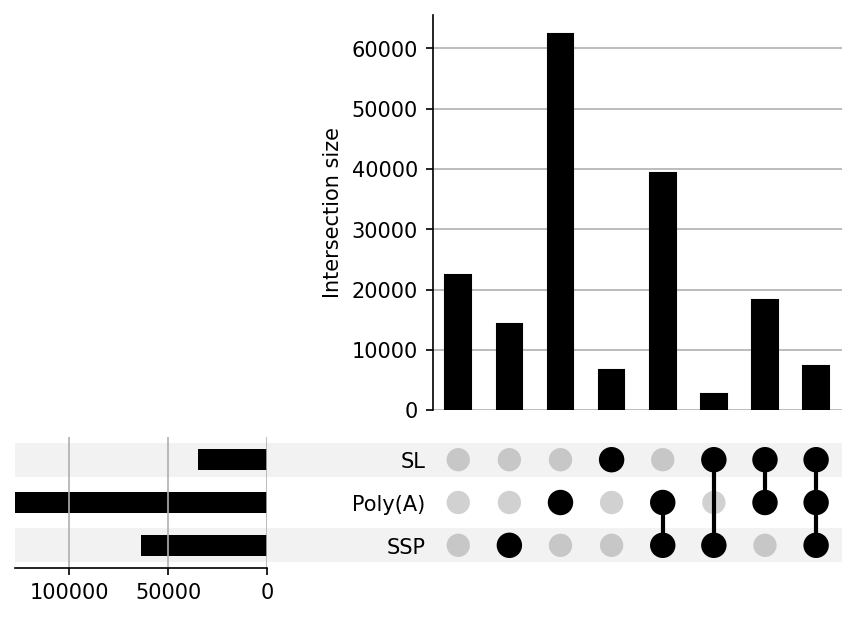

In [19]:
%matplotlib inline

# Count genes per set
short_antisense_cat = short_antisense_summary.groupby(['SSP', 'Poly(A)', 'SL']).size()

# Show upset plot
upset_plot = plot(short_antisense_cat, fig=plt.figure(figsize=(8,4),dpi=150), sort_categories_by=None, facecolor='k', sort_by='degree', totals_plot_elements=5, intersection_plot_elements=8)

# Save plot
plt.savefig('SupFig3.a-upset_adapter_search_(antisense_short_5SC).pdf', dpi=800, bbox_inches='tight')

<font size="4">**Sup. Fig 3.a:**<br></font>
For each read evaluated, we performed a sequence search for the SSP and SL motifs on the 5’ soft-clip region, and for the poly(A) motif on the 3’ soft-clip region.
**Antisense reads & short 5’ soft-clip :** (n = 173,621 reads)

<br>

## c) Analysis of Antisense reads with long 5' soft-clip

In [20]:
long_antisense_summary = long_antisense[['ROBUST_SL_FOUND','SSP_FOUND','PolyA_FOUND']].copy()
long_antisense_summary.columns = ['SL', 'SSP', 'Poly(A)']
long_antisense_summary['SL'] = long_antisense_summary['SL'].map({'NOT FOUND':False, 'FOUND':True})
long_antisense_summary['SSP'] = long_antisense_summary['SSP'].map({'NOT FOUND':False, 'FOUND':True})

In [21]:
measure_sequence_found(long_antisense_summary)

,SSP,SL,Poly(A)
False,1954652,1340800,491378
True,33276,647128,1496550


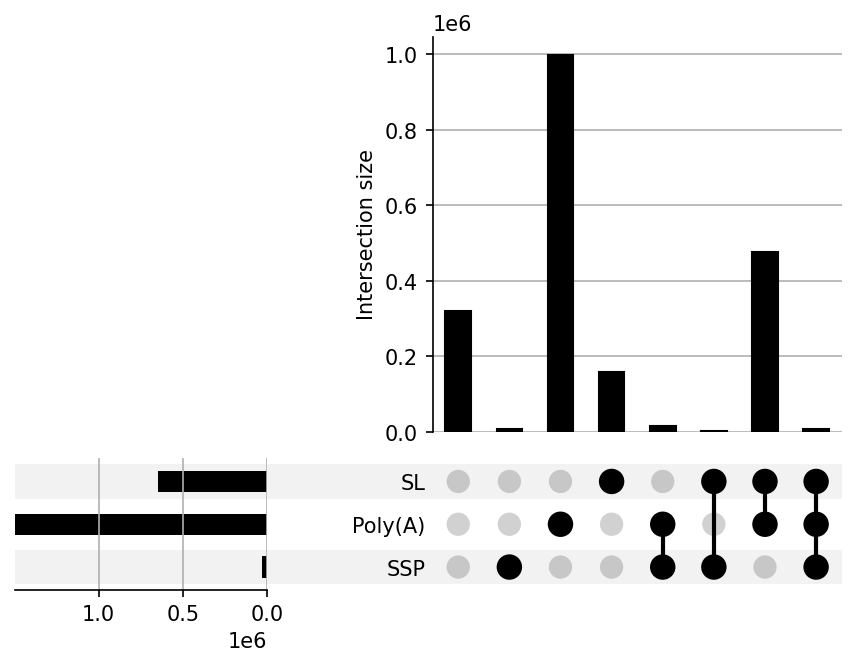

In [22]:
%matplotlib inline

# Count genes per set
long_antisense_cat = long_antisense_summary.groupby(['SSP', 'Poly(A)', 'SL']).size()

# Show upset plot
upset_plot = plot(long_antisense_cat, fig=plt.figure(figsize=(8,4),dpi=150), sort_categories_by=None, facecolor='k', sort_by='degree', totals_plot_elements=5, intersection_plot_elements=8)

# Save plot
plt.savefig('SupFig3.a-upset_adapter_search_(antisense_long_5SC).pdf', dpi=800, bbox_inches='tight')

<font size="4">**Sup. Fig 3.a:**<br></font>
For each read evaluated, we performed a sequence search for the SSP and SL motifs on the 5’ soft-clip region, and for the poly(A) motif on the 3’ soft-clip region.
**Antisense reads & long 5’ soft-clip :** (n = 1,987,928 reads)

<br>

# Panel b: Origin of supplementary alignments

In [23]:
PA_name = []
PA_ref = []
PA_ts = []       
SA_ref = []
SA_ts = []

total_reads = 0
SA_reads = 0


runs = ['SSP_1', 'SSP_2', 'SSP_3']

for ID in runs:

    input_file = f'{path}/{ID}/{ID}-transcriptome_sorted.bam'

    with pysam.AlignmentFile(input_file,'rb') as alignments:

        for read in alignments:

            # Take only primary read so we don't get duplicated SA
            if not read.is_unmapped and not read.is_supplementary and read.seq is not None:
                
                # count primary
                total_reads = total_reads + 1
                
                # Take reads who have a SA
                if read.has_tag('SA'):
                    
                    # count primary who has SA
                    SA_reads = SA_reads + 1

                    # Get infos on read
                    name = read.query_name
                    aln_ref = alignments.get_reference_name(read.reference_id)
                    aln_ts = '-' if read.is_reverse else '+'

                    # Get the SA string
                    SA = read.get_tag('SA')

                    # Split the strings into different SA if there more than 1
                    x = SA.split(';')

                    # iterate over each SA
                    for i in range(0, SA.count(';')):

                        ref, map_pos, ts, cigar, mapQ, edist = x[i].split(',')

                        # store values into lists
                        PA_name.append(name)
                        
                        PA_ref.append(aln_ref)
                        PA_ts.append(aln_ts)

                        SA_ref.append(ref)
                        SA_ts.append(ts)

                        
alignments_stats = pd.DataFrame(dict(primary_name=PA_name, primary_ref=PA_ref, primary_ts=PA_ts, supplementary_ref=SA_ref, supplementary_ts=SA_ts))


In [24]:
alignments_stats

,primary_name,primary_ref,primary_ts,supplementary_ref,supplementary_ts
0,6280d610-7c3f-426a-9a77-7ee663a1097d,2RSSE.1a.1,-,2RSSE.1c.1,+
1,694b4446-a948-47ae-9b6d-9b6bbb78f9f9,3R5.1a.1,+,3R5.1a.1,-
2,2abf03ab-8b41-4212-b53f-0fdfb2d6582c,3R5.1b.1,-,3R5.1b.1,+
3,6585d098-1026-4199-a72e-4b87ddb2c735,3R5.1b.1,-,3R5.1b.1,+
4,b9ce965a-fa37-4c89-844c-24a197f5ae04,AC3.10.1,-,AC3.10.1,+
...,...,...,...,...,...
443237,c37ec0e0-6d0f-4775-978f-a55fff68241e,ZK973.9.1,-,ZK973.9.1,+
443238,1e0e4317-3038-4cb6-969e-22597b21819f,ZK973.9.1,-,ZK973.9.1,+
443239,2125781c-a8bd-451b-91aa-6f3f74b9bbbd,cTel55X.1a.1,-,cTel55X.1a.1,+
443240,4c9cc5e0-e976-47de-aef5-0f7fea3bd5f8,cTel55X.1a.1,-,cTel55X.1a.1,+


In [25]:
alignments_stats['same_gene'] = alignments_stats.apply(lambda x: True if re.findall(r"\w+.\d+\B", x['primary_ref']) == re.findall(r"\w+.\d+\B", x['supplementary_ref']) else False, axis=1)
alignments_stats['same_ts'] = alignments_stats.apply(lambda x: True if x['primary_ts'] == x['supplementary_ts'] else False, axis=1)

alignments_stats['same_gene'] = alignments_stats['same_gene'].map({True: 'Same gene', False: 'Different gene' })
alignments_stats['same_ts'] = alignments_stats['same_ts'].map({True:'Same strand' , False: 'Opposite strand' })


In [26]:
percent = round(SA_reads/total_reads*100, 2)

print(f'primary alignments : {total_reads}')
print(f'supplementary alignments : {SA_reads} ({percent}%)')

primary alignments : 1337404
supplementary alignments : 436088 (32.61%)


In [27]:
aln_dict = {'No Supplementary alignments': (total_reads - SA_reads), 'Supplementary alignments': SA_reads}
aln_stats = pd.DataFrame.from_dict(aln_dict, orient='index', columns=['Total']).T
aln_stats

,No Supplementary alignments,Supplementary alignments
Total,901316,436088


In [28]:
aln_1match = alignments_stats.drop_duplicates(subset='primary_name')

sup_aln = aln_1match.groupby(['same_gene', 'same_ts']).size().reset_index().pivot(columns='same_ts', index='same_gene', values=0)
sup_aln = sup_aln.sort_index(ascending=False)
sup_aln = sup_aln[['Same strand', 'Opposite strand']]
sup_aln

same_ts,Same strand,Opposite strand
same_gene,,
Same gene,2225,424411
Different gene,4094,5358


In [29]:
sup_aln = alignments_stats.groupby(['same_gene', 'same_ts']).size().reset_index().pivot(columns='same_ts', index='same_gene', values=0)
sup_aln = sup_aln.sort_index(ascending=False)
sup_aln = sup_aln[['Same strand', 'Opposite strand']]
sup_aln

same_ts,Same strand,Opposite strand
same_gene,,
Same gene,3715,428034
Different gene,4880,6613


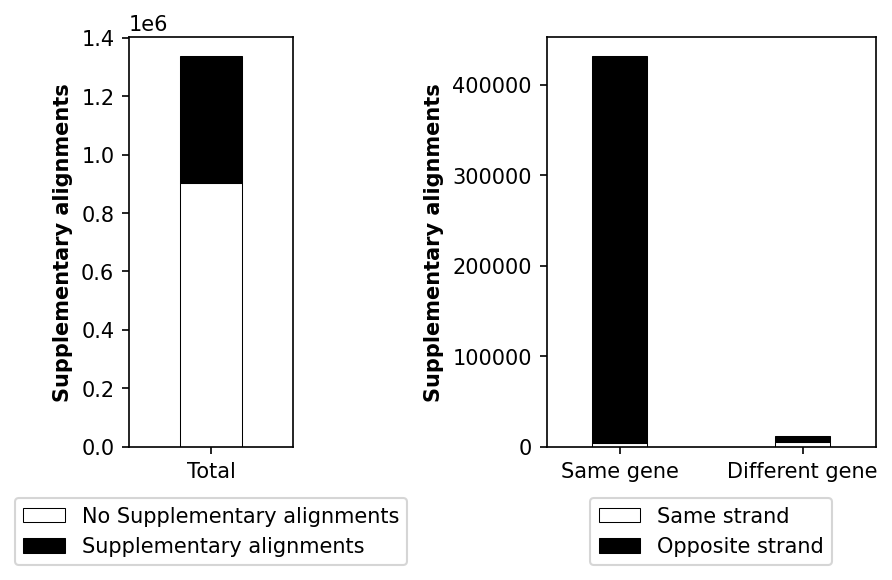

In [30]:
%matplotlib inline

fig, ax = plt.subplots(ncols=2, sharey=False, dpi=150, gridspec_kw={ 'width_ratios': [1, 2]})

aln_stats.plot(kind='bar', stacked=True, ax=ax[0], rot=0, width=0.3, color=['#ffffff', '#000000'], linewidth=0.5, edgecolor='black')
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
ax[0].set_ylabel('Supplementary alignments', weight='bold')


sup_aln.plot(kind='bar', stacked=True, ax=ax[1],rot=0, width=0.3, color=['#ffffff', '#000000'], linewidth=0.5, edgecolor='black')
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
ax[1].set_xlabel('')
ax[1].set_ylabel('Supplementary alignments', weight='bold')

# general plot settings
plt.subplots_adjust(left=0.1, bottom=None, right=0.98, top=None, wspace=1, hspace=None)
plt.tight_layout()

# save
plt.savefig('SupFig3.b-origin_of_supplementary_alignments.pdf', dpi=800, bbox_inches='tight')

<font size="4">**Sup. Fig 3.b:**<br></font>
32.6% of aligned reads with with long 5’
soft-clip have supplementary alignments. Among those, 98% are mapping to the same gene than the primary
alignment, but in the opposite orientation. 32.6% of reads with primary alignments possess supplementary
alignments. Among those, 98% are mapped to the same gene as in the primary alignment, but in the
opposite orientation.

<br>

# Panel c: Size distribution of supplementary alignments

In [31]:
PA_name = []
PA_length = []
SA_name = []
SA_length = []

runs = ['SSP_1', 'SSP_2', 'SSP_3', 'SSP_4', 'SSP_5', 'SSP_6']

for ID in runs:

    input_file = f'{path}/{ID}/{ID}-transcriptome_sorted.bam'

    with pysam.AlignmentFile(input_file,'rb') as alignments:

        for read in alignments:
            
            if read.is_supplementary:
                
                SA_length.append(read.query_alignment_length)
                SA_name.append(read.query_name)
            
            if not read.is_supplementary and not read.is_secondary:
                
                PA_length.append(read.query_alignment_length)
                PA_name.append(read.query_name)


primary = pd.DataFrame(dict(read=PA_name, primary_length=PA_length))
primary = primary.set_index('read')

supplementary = pd.DataFrame(dict(read=SA_name, supplementary_length=SA_length))
supplementary = supplementary.drop_duplicates(['read'], keep=False)
supplementary = supplementary.set_index('read')

primary_plus_supplementary = pd.concat([primary, supplementary], axis=1)
primary_plus_supplementary = primary_plus_supplementary.reindex(supplementary.index)
primary_plus_supplementary = primary_plus_supplementary.astype(int)

In [32]:
primary_plus_supplementary['ratio'] = primary_plus_supplementary['supplementary_length']/primary_plus_supplementary['primary_length']*100

In [33]:
# take a sub-samble for faster computing (100K datapoints)
p = primary_plus_supplementary.sample(n=100000)

# Calculate point density
val = np.vstack([p['supplementary_length'], p['primary_length']])
p['gaussian'] = gaussian_kde(val)(val)

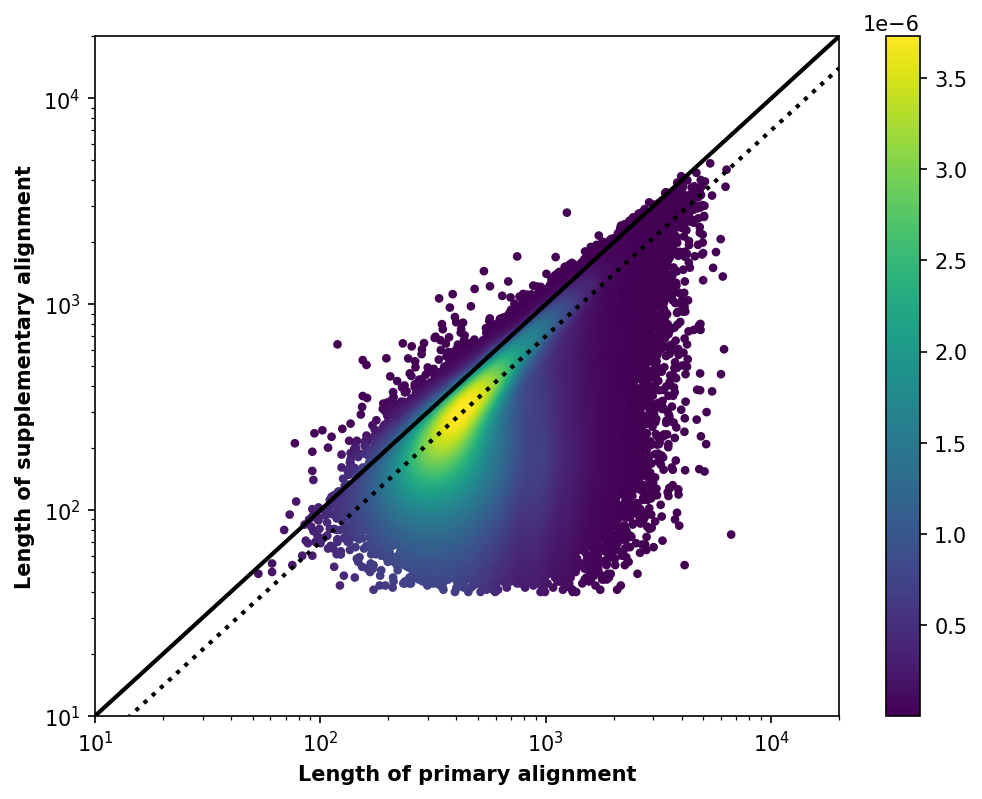

In [34]:
%matplotlib inline

plt.figure(figsize=(8,6), dpi=150)

plt.scatter(x='primary_length', y='supplementary_length', data=p.sort_values('gaussian'), 
            c='gaussian', cmap='viridis', s=10)


plt.plot([1, 20000], [1, 20000],'k', linewidth=2)
plt.plot([1, 20000], [0.70, 14000],'k:', linewidth=2)

plt.ylabel('Length of supplementary alignment', weight='bold')
plt.xlabel('Length of primary alignment', weight='bold')
plt.xscale('log')
plt.yscale('log')

plt.xlim(10,20000)
plt.ylim(10,20000)

# (generate plot here)
cb = plt.colorbar() 

plt.savefig('SupFig3.c-size_distribution_of_supplementary_alignments.png', dpi=800, bbox_inches='tight')

<font size="4">**Sup. Fig 3.c:**<br></font>
Sizes of primary and supplementary alignments were compared for reads possessing both.\
Solid black line represent supplementary alignments that are the same size as their primary alignment (ratio 1/1).\
Dotted black line represent supplementary alignments that 70% of the size of their primary alignment (ratio 1/0.7).